In [7]:
import os
import sys
from functools import partial

import yaml

import matplotlib.pyplot as plt
import numpy as np
import casadi as cs

from safe_control_gym.envs.benchmark_env import Environment, Task

from safe_control_gym.hyperparameters.hpo import HPO
from safe_control_gym.experiments.base_experiment import BaseExperiment
from safe_control_gym.utils.configuration import ConfigFactory
from safe_control_gym.utils.registration import make
from safe_control_gym.utils.utils import set_device_from_config, set_dir_from_config, set_seed_from_config

# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
def train(config):
    """Training for a given set of hyperparameters.

    Usage:
        * to start training, use with `--func train`.

    """

MAIN_FUNCS = {'train': train}


# Make config.
# ALGO = 'gp_mpc'
ALGO = 'gpmpc_acados'
# SYS = 'cartpole'
# TASK = 'stab'
SYS = 'quadrotor_2D_attitude'
TASK = 'track'
PRIOR = '150'
agent = 'quadrotor' if SYS == 'quadrotor_2D' or SYS == 'quadrotor_2D_attitude' else SYS
# check if the config file exists
assert os.path.exists(f'./{ALGO}/config_overrides/{SYS}/{SYS}_{TASK}.yaml'), f'./{ALGO}/config_overrides/{SYS}/{SYS}_{TASK}.yaml does not exist'
assert os.path.exists(f'./{ALGO}/config_overrides/{SYS}/{ALGO}_{SYS}_{PRIOR}.yaml'), f'./{ALGO}/config_overrides/{SYS}/{ALGO}_{SYS}_{PRIOR}.yaml does not exist'
sys.argv[1:] = ['--algo', ALGO,
                '--task', agent,
                '--overrides',
                    f'./{ALGO}/config_overrides/{SYS}/{SYS}_{TASK}.yaml',
                    f'./{ALGO}/config_overrides/{SYS}/{ALGO}_{SYS}_{PRIOR}.yaml',
                '--seed', '2',
                '--use_gpu', 'True',
                '--output_dir', f'./{ALGO}/results',
                    ]
fac = ConfigFactory()
fac.add_argument('--func', type=str, default='train', help='main function to run.')
fac.add_argument('--n_episodes', type=int, default=1, help='number of episodes to run.')
# merge config
config = fac.merge()

In [9]:
# Experiment setup.
set_seed_from_config(config)
set_device_from_config(config)

# Define function to create task/env.
env_func = partial(make, config.task, output_dir=config.output_dir, **config.task_config)
# Create the controller/control_agent.
# Note:
# eval_env will take config.seed * 111 as its seed
# env will take config.seed as its seed
control_agent = make(config.algo,
                        env_func,
                        training=True,
                        checkpoint_path=os.path.join(config.output_dir, 'model_latest.pt'),
                        output_dir=config.output_dir,
                        use_gpu=config.use_gpu,
                        seed=config.seed,
                        **config.algo_config)
control_agent.reset()

eval_env = env_func(seed=config.seed * 111)

experiment = BaseExperiment(eval_env, control_agent)
# if config.algo_config.gp_model_path is not None:
#     control_agent.load(config.algo_config.gp_model_path)
# else:
#     experiment.launch_training()
control_agent.load(config.algo_config.gp_model_path)
# results, metrics = experiment.run_evaluation(n_episodes=config.n_episodes, n_steps=None, done_on_max_steps=True)
# control_agent.close()




=================Resetting MPC=================
=================Resetting MPC=================
=================Setting up acados optimizer=================
 If there is an incompatibility with the CasADi generated code, please consider changing your CasADi version.
Version 3.6.5 currently in use.
rm -f libacados_ocp_solver_quadrotor.so
rm -f acados_solver_quadrotor.o
cc -fPIC -std=c99   -O2 -I/home/mingxuan/Repositories/acados/include -I/home/mingxuan/Repositories/acados/include/acados -I/home/mingxuan/Repositories/acados/include/blasfeo/include -I/home/mingxuan/Repositories/acados/include/hpipm/include  -c -o acados_solver_quadrotor.o acados_solver_quadrotor.c
cc -fPIC -std=c99   -O2 -I/home/mingxuan/Repositories/acados/include -I/home/mingxuan/Repositories/acados/include/acados -I/home/mingxuan/Repositories/acados/include/blasfeo/include -I/home/mingxuan/Repositories/acados/include/hpipm/include  -c -o quadrotor_model/quadrotor_dyn_disc_phi_fun.o quadrotor_model/quadrotor_dyn_disc_

/home/mingxuan/.local/lib/python3.8/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [10]:
init_state = control_agent.env.reset()
print('init_state:', init_state)
ref = control_agent.get_references()
print('ref.shape:', ref.shape)

control_agent.reset()

control_agent.compute_initial_guess(init_state, control_agent.get_references())
ol_input = control_agent.u_guess
ol_state = control_agent.x_guess
print('test_input.shape:', ol_input.shape)
# print('test_input:', test_input)




init_state: [ 0.   0.   1.2  0.  -0. ]
ref.shape: (5, 26)
=================Setting up acados optimizer=================
=========== Resetting prior controller ===========
=================Resetting MPC=================
Computing initial guess for GP MPC.
Setting up GP MPC with ipopt solver.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1005
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:     1065

Total number of variables............................:  

In [11]:

control_agent.select_action(init_state)
acados_input = control_agent.u_prev
acados_state = control_agent.x_prev
print('acados_input.shape:', acados_input.shape)
print('acados_state.shape:', acados_state.shape)

horizon = ol_input.shape[1]

current obs: [ 0.   0.   1.2  0.  -0. ]
acados warmstarting time: 0.0004665851593017578
acados returned status 0. 
gpmpc acados action selection time: 0.0020017623901367188
acados_input.shape: (2, 25)
acados_state.shape: (5, 26)


In [12]:
# simulation with environment
init_state = control_agent.env.reset()
obs_list = []
for idx in range(horizon):
    obs, _, _, _ = control_agent.env.step(ol_input[:, idx])
    obs_list.append(obs)
obs_list = np.array(obs_list)
print('obs_list.shape:', obs_list.shape)

# simulation with acados input 
init_state = control_agent.env.reset()
obs_list_acados = []
x = acados_state
for idx in range(horizon):
    obs, _, _, _ = control_agent.env.step(acados_input[:, idx])
    obs_list_acados.append(obs)
obs_list_acados = np.array(obs_list_acados)
print('obs_list_acados.shape:', obs_list_acados.shape)

x = cs.SX.sym('x', 5)
u = cs.SX.sym('u', 2)
z = cs.vertcat(x, u)
x_next = control_agent.prior_dynamics_func(x0 = x - control_agent.X_EQ, p = u - control_agent.U_EQ)['xf']\
            + control_agent.X_EQ + control_agent.Bd @ control_agent.gaussian_process.casadi_predict(z=z)['mean']
pred_dyn_func = cs.Function('pred_dyn_func', [x, u], [x_next])



# simulation with dynamics (ipopt input)
obs_list_dyn = []
x = obs_list[0]
for idx in range(horizon):
    u = ol_input[:, idx]
    x = pred_dyn_func(x, u)
    obs_list_dyn.append(x)
obs_list_dyn = np.array(obs_list_dyn)

# simulation with dynamics (acados input)
obs_list_dyn_acados = []
x = obs_list_acados[0]
for idx in range(horizon):
    u = acados_input[:, idx]
    x = pred_dyn_func(x, u)
    obs_list_dyn_acados.append(x)
obs_list_dyn_acados = np.array(obs_list_dyn_acados)

obs_list.shape: (25, 5)
obs_list_acados.shape: (25, 5)


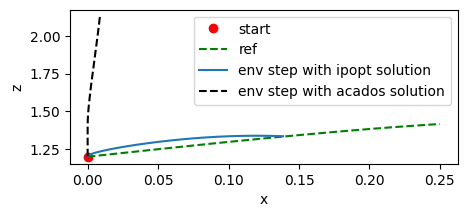

In [13]:
# compare dynamics
plt.figure(figsize=(5, 2))
plt.plot(obs_list[0, 0], obs_list[0, 2], 'ro', label='start')
plt.plot(ref[0, :], ref[2, :], label='ref', linestyle='--', color='g')
plt.plot(obs_list[:, 0], obs_list[:, 2], label='env step with ipopt solution')
plt.plot(obs_list_acados[:, 0], obs_list_acados[:, 2], label='env step with acados solution', color='black', linestyle='--')
plt.xlabel('x')
plt.ylabel('z')
plt.legend()
plt.show()

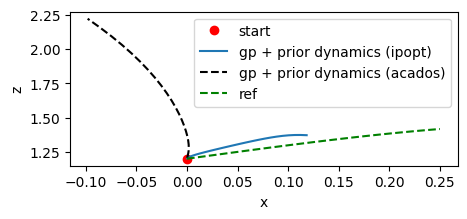

In [14]:
plt.figure(figsize=(5, 2))
plt.plot(obs_list[0, 0], obs_list[0, 2], 'ro', label='start')
plt.plot(obs_list_dyn[:, 0], obs_list_dyn[:, 2], label='gp + prior dynamics (ipopt)')
plt.plot(obs_list_dyn_acados[:, 0], obs_list_dyn_acados[:, 2], label='gp + prior dynamics (acados)', color='black', linestyle='--')
plt.plot(ref[0, :], ref[2, :], label='ref', linestyle='--', color='g')
plt.xlabel('x')
plt.ylabel('z')
plt.legend()

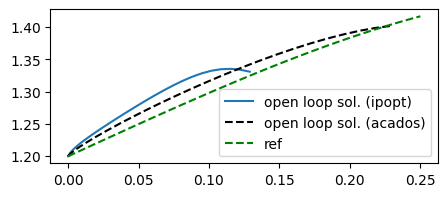

In [15]:
# compare open loop solutions
plt.figure(figsize=(5, 2))
plt.plot(ol_state[0, :], ol_state[2, :], label='open loop sol. (ipopt)')
plt.plot(acados_state[0, :], acados_state[2, :], label='open loop sol. (acados)', color='black', linestyle='--')
plt.plot(ref[0, :], ref[2, :], label='ref', linestyle='--', color='g')
plt.legend()


In [16]:
test_state = np.array([0., 
init_state = control_agent.env.reset(
print('init_state:', init_state)

control_agent.compute_initial_guess(init_state, control_agent.get_references())
ol_input = control_agent.u_guess
ol_state = control_agent.x_guess
print('test_input.shape:', ol_input.shape)
# print('test_input:', test_input)

horizon = ol_input.shape[1]

# simulation with environment
obs_list = []
for idx in range(horizon):
    obs, _, _, _ = control_agent.env.step(ol_input[:, idx])
    obs_list.append(obs)
obs_list = np.array(obs_list)
print('obs_list.shape:', obs_list.shape)

# simulation with dynamics
x = cs.SX.sym('x', 5)
u = cs.SX.sym('u', 2)
z = cs.vertcat(x, u)
x_next = control_agent.prior_dynamics_func(x0 = x - control_agent.X_EQ, p = u - control_agent.U_EQ)['xf']\
            + control_agent.X_EQ + control_agent.Bd @ control_agent.gaussian_process.casadi_predict(z=z)['mean']
pred_dyn_func = cs.Function('pred_dyn_func', [x, u], [x_next])

obs_list_dyn = []
x = obs_list[0]
for idx in range(horizon):
    u = ol_input[:, idx]
    x = pred_dyn_func(x, u)
    obs_list_dyn.append(x)
obs_list_dyn = np.array(obs_list_dyn)

plt.figure(figsize=(5, 2))
plt.plot(obs_list[:, 0], obs_list[:, 2], label='env step')
plt.plot(obs_list_dyn[:, 0], obs_list_dyn[:, 2], label='gp + prior dynamics')
plt.plot(ol_state[0, :], ol_state[2, :], label='open loop sol.')
plt.plot(obs_list[0, 0], obs_list[0, 2], 'ro', label='start')
plt.xlabel('x')
plt.ylabel('z')
plt.legend()
plt.show()


SyntaxError: invalid syntax (802097563.py, line 2)

In [ ]:
# plotting 
if config.task == Environment.QUADROTOR:
    system = f'quadrotor_{str(config.task_config.quad_type)}D'
    if config.task_config.quad_type == 4:
        system = 'quadrotor_2D'
else:
    system = config.task

if True:
    if system == Environment.CARTPOLE:
        graph1_1 = 2
        graph1_2 = 3
        graph3_1 = 0
        graph3_2 = 1
    elif system == 'quadrotor_2D':
        graph1_1 = 4
        graph1_2 = 5
        graph3_1 = 0
        graph3_2 = 2
    elif system == 'quadrotor_3D':
        graph1_1 = 6
        graph1_2 = 9
        graph3_1 = 0
        graph3_2 = 4
    
    if config.task_config.quad_type != 4:
        _, ax = plt.subplots()
        ax.plot(results['obs'][0][:, graph1_1], results['obs'][0][:, graph1_2], 'r--', label='Agent Trajectory')
        ax.scatter(results['obs'][0][0, graph1_1], results['obs'][0][0, graph1_2], color='g', marker='o', s=100, label='Initial State')
        ax.set_xlabel(r'$\theta$')
        ax.set_ylabel(r'$\dot{\theta}$')
        ax.set_box_aspect(0.5)
        ax.legend(loc='upper right')
        # save the plot
        plt.savefig(os.path.join(config.output_dir, 'trajectory_theta_theta_dot.png'))

        if config.task_config.task == Task.TRAJ_TRACKING and config.task == Environment.CARTPOLE:
            _, ax2 = plt.subplots()
            ax2.plot(np.linspace(0, 20, results['obs'][0].shape[0]), results['obs'][0][:, 0], 'r--', label='Agent Trajectory')
            ax2.plot(np.linspace(0, 20, results['obs'][0].shape[0]), eval_env.X_GOAL[:, 0], 'b', label='Reference')
            ax2.set_xlabel(r'Time')
            ax2.set_ylabel(r'X')
            ax2.set_box_aspect(0.5)
            ax2.legend(loc='upper right')
            # save the plot
            plt.savefig(os.path.join(config.output_dir, 'trajectory_time_x.png'))
        elif config.task == Environment.QUADROTOR:
            _, ax2 = plt.subplots()
            ax2.plot(results['obs'][0][:, graph3_1 + 1], results['obs'][0][:, graph3_2 + 1], 'r--', label='Agent Trajectory')
            ax2.set_xlabel(r'x_dot')
            ax2.set_ylabel(r'z_dot')
            ax2.set_box_aspect(0.5)
            ax2.legend(loc='upper right')
            # save the plot
            plt.savefig(os.path.join(config.output_dir, 'trajectory_x_dot_z_dot.png'))

    _, ax3 = plt.subplots()
    ax3.plot(results['obs'][0][:, graph3_1], results['obs'][0][:, graph3_2], 'r--', label='Agent Trajectory')
    if config.task_config.task == Task.TRAJ_TRACKING and config.task == Environment.QUADROTOR:
        ax3.plot(eval_env.X_GOAL[:, graph3_1], eval_env.X_GOAL[:, graph3_2], 'g--', label='Reference')
    ax3.scatter(results['obs'][0][0, graph3_1], results['obs'][0][0, graph3_2], color='g', marker='o', s=100, label='Initial State')
    ax3.set_xlabel(r'X')
    if config.task == Environment.CARTPOLE:
        ax3.set_ylabel(r'Vel')
    elif config.task == Environment.QUADROTOR:
        ax3.set_ylabel(r'Z')
    ax3.set_box_aspect(0.5)
    ax3.legend(loc='upper right')

    plt.tight_layout()
    # save the plot
    plt.savefig(os.path.join(config.output_dir, 'trajectory_x.png'))

# save to pickle
with open(os.path.join(config.output_dir, 'metrics.pkl'), 'wb') as f:
    import pickle
    pickle.dump(metrics, f)
